In [13]:
#Import libraries
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

In [3]:
#Download data
ticker = "BAC"
tickerdata = yf.Ticker(ticker)
tickerDf = tickerdata.history(period="1d", start='2010-1-1', end='2020-8-16')

In [11]:
priceData = tickerDf.Close
priceData = priceData.asfreq(pd.infer_freq(priceData.index))
priceData

Date
2010-01-04    13.91
2010-01-05    14.37
2010-01-06    14.53
2010-01-07    15.01
2010-01-08    14.88
              ...  
2020-08-10    26.56
2020-08-11    26.92
2020-08-12    26.73
2020-08-13    26.35
2020-08-14    26.47
Freq: D, Name: Close, Length: 3876, dtype: float64

Text(0.5, 1.0, 'BAC Price Data')

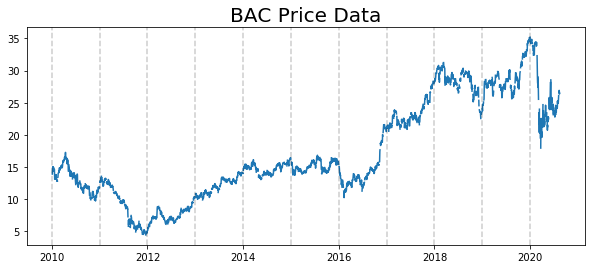

In [17]:
#Plot the data
plt.figure(figsize=(10,4))
plt.plot(priceData)
for year in range(priceData.index[0].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1),color="k",linestyle='--',alpha=0.2)
plt.title('%s Price Data'%ticker, fontsize=20)

In [18]:
#Buy if price increase for x days consecutively
#Sell if price decrease for y days consecutively
def buying_condition(series):
    return (series>0).all()

def selling_condition(series):
    return (series<0).all()

def get_buy_sell_days(price_data, x, y):
    #percentage change
    pct_change = price_data.pct_change()[1:]
    buying_days = pct_change.rolling(x).apply(buying_condition)
    selling_days = pct_change.rolling(y).apply(selling_condition)
    return {"buying_days":buying_days, 'selling_days': selling_days}

In [20]:
#Guess that three days are enought to show momentum
Guess = get_buy_sell_days(priceData, 3,3)
buying_days = Guess["buying_days"]
selling_days = Guess["selling_days"]

In [28]:
#Create a data frame of only buying/selling days
df_stocks = pd.DataFrame(index = buying_days.index)
df_stocks['buying_days'] = (buying_days == 1)
df_stocks['selling_days'] = (selling_days == 1)
df_stocks['price'] = priceData
df_stocks = df_stocks[(df_stocks.buying_days | df_stocks.selling_days)]
df_stocks.head()

,buying_days,selling_days,price
Date,,,
2010-01-07,True,False,15.01
2010-02-18,True,False,14.08
2010-02-26,True,False,14.77
2010-03-10,True,False,15.18
2010-03-11,True,False,15.19


In [53]:
#The 3-day trend trading stragtegy
def get_investing_result(df_stocks, starting_funds, verbose=False):
    #get a copy of price data
    price_data = df_stocks.price
    
    #Holding
    holding = False
    
    #Starting fund
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #buying and selling dates
    events_list = []
    for date, data in df_stocks.iterrows():
        if (not holding) and data.buying_days:
            num_shares_to_buy = int(current_funds/data.price)
            current_shares += num_shares_to_buy
            current_funds -= num_shares_to_buy * data.price
            last_buy_date = date
            events_list.append(('b',date))
            holding = True
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, last_buy_date, current_funds))
        elif holding and data.selling_days:
            current_funds += current_shares * data.price
            if verbose:
                print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date, current_funds))
                current_shares = 0
                holding = False
                events_list.append(('s',date))
    final_stock_price = price_data[-1]
    final_value = current_funds + final_stock_price * current_shares
    return round((final_value - starting_funds)/starting_funds,2), events_list

In [54]:
#See how this trend trading stragegy performed on BAC
percent_change, events_list = get_investing_result(df_stocks, 10000, True)

Bought 666 shares at $15.01 on 2010-01-07 00:00:00 totaling $3.3400000000001455
Sold 666 shares at $14.45 on 2010-05-06 00:00:00 totaling $9627.039999999999
Bought 729 shares at $13.19 on 2010-07-08 00:00:00 totaling $11.529999999998836
Sold 729 shares at $12.45 on 2010-08-05 00:00:00 totaling $9087.579999999998
Bought 770 shares at $11.8 on 2010-09-02 00:00:00 totaling $1.5799999999981083
Sold 770 shares at $11.7 on 2010-09-23 00:00:00 totaling $9010.579999999998
Bought 820 shares at $10.98 on 2010-11-05 00:00:00 totaling $6.9799999999977445
Sold 820 shares at $10.33 on 2010-11-17 00:00:00 totaling $8477.579999999998
Bought 803 shares at $10.55 on 2010-12-03 00:00:00 totaling $5.929999999996653
Sold 803 shares at $10.93 on 2010-12-15 00:00:00 totaling $8782.719999999996
Bought 738 shares at $11.9 on 2010-12-22 00:00:00 totaling $0.5199999999949796
Sold 738 shares at $12.05 on 2011-01-26 00:00:00 totaling $8893.419999999995
Bought 728 shares at $12.21 on 2011-04-06 00:00:00 totaling $4

In [58]:
print(percent_change)

0.99


(4, 36)

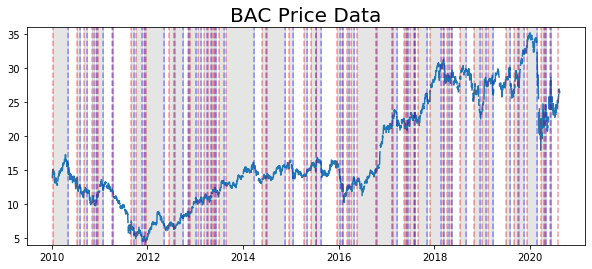

In [59]:
#Visualizing the effect
plt.figure(figsize = (10,4))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)
for idx, event in enumerate(events_list):
    color = "red" if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color = color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), event[1],events_list[idx-1][1],color='k',alpha=0.1)
plt.title("%s Price Data"%ticker, fontsize=20)
plt.ylim(*y_lims)

What if we don't sell when we are not making a profit? I will modified the existing trend strategy

In [60]:
#What if we don't sell when we are not making a profit
def check_cumulative_percent_change(price_data, buy_date, sell_date):
    #Get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    series = 1+pct_change[buy_date+timedelta(hours=1): sell_date]
    return series.product() > 1

In [61]:
#The modified 3-day trand trading strategy
def get_investing_result_2(df_stocks, starting_funds, verbose=False):
    #get a copy of price data
    price_data = df_stocks.price
    
    #Holding
    holding = False
    
    #Starting fund
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #buying and selling dates
    events_list = []
    for date, data in df_stocks.iterrows():
        if (not holding) and data.buying_days:
            num_shares_to_buy = int(current_funds/data.price)
            current_shares += num_shares_to_buy
            current_funds -= num_shares_to_buy * data.price
            last_buy_date = date
            events_list.append(('b',date))
            holding = True
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, last_buy_date, current_funds))
        elif holding and data.selling_days:
            if check_cumulative_percent_change(price_data, last_buy_date, date):
                current_funds += current_shares * data.price
                if verbose:
                    print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date, current_funds))
                    current_shares = 0
                    holding = False
                    events_list.append(('s',date))
    final_stock_price = price_data[-1]
    final_value = current_funds + final_stock_price * current_shares
    return round((final_value - starting_funds)/starting_funds,2), events_list                              

In [62]:
#See how this new trend trading stragegy performed on BAC
percent_change, events_list = get_investing_result_2(df_stocks, 10000, True)

Bought 666 shares at $15.01 on 2010-01-07 00:00:00 totaling $3.3400000000001455
Sold 666 shares at $15.48 on 2014-03-26 00:00:00 totaling $10313.02
Bought 777 shares at $13.27 on 2014-05-23 00:00:00 totaling $2.2300000000013824
Sold 777 shares at $13.9 on 2014-06-26 00:00:00 totaling $10802.530000000002
Bought 755 shares at $14.29 on 2014-07-02 00:00:00 totaling $13.580000000003565
Sold 755 shares at $15.58 on 2014-11-13 00:00:00 totaling $11776.480000000003
Bought 736 shares at $15.99 on 2014-12-19 00:00:00 totaling $7.8400000000037835
Sold 736 shares at $21.14 on 2017-02-08 00:00:00 totaling $15566.880000000005
Bought 678 shares at $22.93 on 2017-02-15 00:00:00 totaling $20.340000000005602
Sold 678 shares at $23.22 on 2017-08-09 00:00:00 totaling $15763.500000000005
Bought 693 shares at $22.73 on 2017-09-01 00:00:00 totaling $11.610000000006039
Sold 693 shares at $25.27 on 2017-11-08 00:00:00 totaling $17523.72000000001
Bought 656 shares at $26.69 on 2017-11-30 00:00:00 totaling $15.

In [63]:
print(percent_change)

0.6


(4, 36)

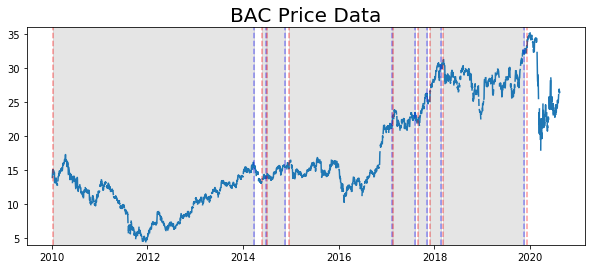

In [52]:
plt.figure(figsize = (10,4))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)
for idx, event in enumerate(events_list):
    color = "red" if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color = color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), event[1],events_list[idx-1][1],color='k',alpha=0.1)
plt.title("%s Price Data"%ticker, fontsize=20)
plt.ylim(*y_lims)